#### The aim of this project is to predict whether a vehicle accident will be fatal. The data was sourced from NZTA's open data portal.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
crashes = pd.read_csv("crashes.csv")
crashes.head()

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1569452.0,5178103.0,1,NaN,595000.0,0.0,NaN,0.0,1.0,NaN,...,NaN,NaN,0.0,0.0,Urban,1.0,NaN,NaN,Fine,Null
1,1906804.0,5572517.0,2,NaN,549100.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine,Null
2,1761685.0,5436885.0,3,NaN,568501.0,0.0,NaN,0.0,2.0,NaN,...,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
3,1793380.0,5500669.0,4,NaN,564220.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,Urban,1.0,0.0,0.0,Fine,Null
4,1312310.0,4948991.0,5,NaN,607800.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,Open,0.0,0.0,0.0,Fine,Null


In [3]:
crashes.columns

Index(['X', 'Y', 'OBJECTID', 'advisorySpeed', 'areaUnitID', 'bicycle',
       'bridge', 'bus', 'carStationWagon', 'cliffBank',
       'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1',
       'crashLocation2', 'crashRoadSideRoad', 'crashSeverity',
       'crashSHDescription', 'crashYear', 'debris', 'directionRoleDescription',
       'ditch', 'fatalCount', 'fence', 'flatHill', 'guardRail', 'holiday',
       'houseOrBuilding', 'intersection', 'kerb', 'light', 'meshblockId',
       'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
       'objectThrownOrDropped', 'otherObject', 'otherVehicleType', 'overBank',
       'parkedVehicle', 'pedestrian', 'phoneBoxEtc', 'postOrPole', 'region',
       'roadCharacter', 'roadLane', 'roadSurface', 'roadworks', 'schoolBus',
       'seriousInjuryCount', 'slipOrFlood', 'speedLimit', 'strayAnimal',
       'streetLight', 'suv', 'taxi', 'temporarySpeedLimit', 'tlaId', 'tlaName',
       'trafficControl', 'trafficIsland', 'trafficSi

#### Remove variables:

In [4]:
cols = ['carStationWagon', 'crashSeverity', 'holiday', 'suv', 'bicycle', 'weatherA', 'light', 'speedLimit', 'motorcycle', 'pedestrian']
crashes = crashes[cols]
crashes.head()

,carStationWagon,crashSeverity,holiday,suv,bicycle,weatherA,light,speedLimit,motorcycle,pedestrian
0,1.0,Non-Injury Crash,NaN,0.0,0.0,Fine,Bright sun,50.0,0.0,NaN
1,1.0,Non-Injury Crash,NaN,0.0,0.0,Fine,Bright sun,50.0,0.0,NaN
2,2.0,Non-Injury Crash,NaN,0.0,0.0,Fine,Bright sun,50.0,0.0,NaN
3,1.0,Non-Injury Crash,NaN,0.0,0.0,Fine,Bright sun,50.0,0.0,NaN
4,1.0,Minor Crash,NaN,0.0,0.0,Fine,Overcast,80.0,0.0,NaN


In [5]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814722 entries, 0 to 814721
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   carStationWagon  814717 non-null  float64
 1   crashSeverity    814722 non-null  object 
 2   holiday          44555 non-null   object 
 3   suv              814717 non-null  float64
 4   bicycle          814717 non-null  float64
 5   weatherA         814722 non-null  object 
 6   light            814722 non-null  object 
 7   speedLimit       813922 non-null  float64
 8   motorcycle       814717 non-null  float64
 9   pedestrian       26280 non-null   float64
dtypes: float64(6), object(4)
memory usage: 62.2+ MB


#### **Variables:**
* carStationWagon: The number of cars in the accident. Float.
* crashSeverity: Whether the crash resulted in an injury or fatality. String.
* holiday: The name of the holiday if the crash occured on one. String
* suv: The number of SUVs involved in the crash. Float.
* bicycle: The number of bicycles involved in the crash. Float.
* weatherA: The type of weather at the time of the crash: String.
* light: The light status at the time of the crash: String.
* speedLimit: The speedLimit of the area the crash occured in: Float.
* motorcycle: The number of motorcycles involved in the crash. Float.
* pedestrian: Whether there was a pedestrian involved in the crash.Float.

#### Converting the holiday column into a binary variable based on whether the crash occured on a holiday or not and filling NAs in the pedestrian column:

In [6]:
# replace holiday column of crashes dataframe with a 0 if NaN
crashes['pedestrian'] = crashes['pedestrian'].fillna(0)
crashes['holiday'] = crashes['holiday'].fillna(0)
# replace values of holiday column with 1 if not 0
crashes['holiday'] = crashes['holiday'].apply(lambda x: 1 if x != 0 else x)
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814722 entries, 0 to 814721
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   carStationWagon  814717 non-null  float64
 1   crashSeverity    814722 non-null  object 
 2   holiday          814722 non-null  int64  
 3   suv              814717 non-null  float64
 4   bicycle          814717 non-null  float64
 5   weatherA         814722 non-null  object 
 6   light            814722 non-null  object 
 7   speedLimit       813922 non-null  float64
 8   motorcycle       814717 non-null  float64
 9   pedestrian       814722 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 62.2+ MB


In [7]:
# print number of missing values for each column in crashes
print(crashes.isnull().sum())

carStationWagon      5
crashSeverity        0
holiday              0
suv                  5
bicycle              5
weatherA             0
light                0
speedLimit         800
motorcycle           5
pedestrian           0
dtype: int64


#### Relatively few missing values, so will just remove.

In [8]:
# remove all rows where any column has a missing value
crashes = crashes.dropna()
crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813917 entries, 0 to 814721
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   carStationWagon  813917 non-null  float64
 1   crashSeverity    813917 non-null  object 
 2   holiday          813917 non-null  int64  
 3   suv              813917 non-null  float64
 4   bicycle          813917 non-null  float64
 5   weatherA         813917 non-null  object 
 6   light            813917 non-null  object 
 7   speedLimit       813917 non-null  float64
 8   motorcycle       813917 non-null  float64
 9   pedestrian       813917 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 68.3+ MB


#### Converting crash severity into a binary variable, 0 if crash had no fatalities, 1 if crash had at least 1:

In [9]:
# Convert crashSeverity into a binary variable, where 0 is not fatal and 1 is fatal.
crashes['crashSeverity'] = crashes['crashSeverity'].apply(lambda x: 1 if x == 'Fatal Crash' else 0)

#### Converting SUV to a binary variable:

In [10]:
# Replace suv column with 1 if value does not equal 0.0
crashes['suv'] = crashes['suv'].astype(int)
crashes['suv'] = crashes['suv'].apply(lambda x: 1 if x != 0.0 else x)

#### Converting bicycle to a binary variable:

In [11]:
crashes['bicycle'] = crashes['bicycle'].astype(int)
crashes['bicycle'] = crashes['bicycle'].apply(lambda x: 1 if x != 0.0 else x)

#### Converting motorcycle to a binary variable:

In [12]:
crashes['motorcycle'] = crashes['motorcycle'].astype(int)
crashes['motorcycle'] = crashes['motorcycle'].apply(lambda x: 1 if x != 0.0 else x)

In [13]:
crashes.head()

,carStationWagon,crashSeverity,holiday,suv,bicycle,weatherA,light,speedLimit,motorcycle,pedestrian
0,1.0,0,0,0,0,Fine,Bright sun,50.0,0,0.0
1,1.0,0,0,0,0,Fine,Bright sun,50.0,0,0.0
2,2.0,0,0,0,0,Fine,Bright sun,50.0,0,0.0
3,1.0,0,0,0,0,Fine,Bright sun,50.0,0,0.0
4,1.0,0,0,0,0,Fine,Overcast,80.0,0,0.0


In [14]:
print(crashes['light'].value_counts())
crashes = crashes[crashes['light'] != 'Unknown']

Bright sun    300472
Overcast      244149
Dark          223540
Twilight       37988
Unknown         7768
Name: light, dtype: int64


#### Removing missing values from light column:

In [15]:
crashes['light'].value_counts()

Bright sun    300472
Overcast      244149
Dark          223540
Twilight       37988
Name: light, dtype: int64

#### Condensing weather variable to have three categories: Fine, Rain, Mist or Fog:

In [16]:
#crashes['weatherA'].value_counts()
# print count of instances where crashSeverity is 1 for each value of weatherA
print("Weather in fatal events:")
print(crashes[crashes['crashSeverity'] == 1]['weatherA'].value_counts())
print("\nAfter condensing: ")
# # filter weatherA column of crashes and replace all values of 'Light rain' and 'Heavy rain' with 'Rain'
crashes['weatherA'] = crashes['weatherA'].apply(lambda x: 'Rain' if x == 'Light rain' or x == 'Heavy rain' else x)
# # filter weatherA column of crashes and remove all rows where value is not 'Fine' or 'Rain' or 'Mist or Fog'
crashes = crashes[(crashes['weatherA'] == 'Fine') | (crashes['weatherA'] == 'Rain') | (crashes['weatherA'] == 'Mist or Fog')]
crashes[crashes['crashSeverity'] == 1]['weatherA'].value_counts()

Weather in fatal events:
Fine             5976
Light rain       1017
Heavy rain        317
Mist or Fog       172
Null               15
Snow               12
Hail or Sleet       1
Name: weatherA, dtype: int64

After condensing: 


Fine           5976
Rain           1334
Mist or Fog     172
Name: weatherA, dtype: int64

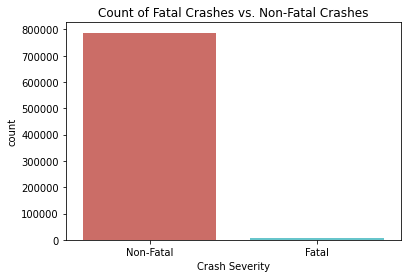

<Figure size 432x288 with 0 Axes>

In [17]:
sns.countplot(x='crashSeverity', data=crashes, palette='hls')
plt.title("Count of Fatal Crashes vs. Non-Fatal Crashes")
plt.xlabel("Crash Severity")
plt.xticks([0, 1], ['Non-Fatal', 'Fatal'])
plt.show()
plt.savefig('count_plot')

#### Crashes involving a fatality relative to total crashes is very small. Will look at proportions based on my variables light and weather instead.

In [18]:
count_survived = len(crashes[crashes['crashSeverity'] == 0])
count_died = len(crashes[crashes['crashSeverity'] == 1])
print("Percentage of people who survived: " + str(count_survived/(count_survived + count_died)))
print("Percentage of people who didn't survive: " + str(1-(count_survived/(count_survived + count_died))))

Percentage of people who survived: 0.9905909871163677
Percentage of people who didn't survive: 0.009409012883632273


#### Due to the imbalanace in proportion of fatalities, I will balance the classes later in the notebook.

In [19]:
crashes.groupby('crashSeverity').mean()

,carStationWagon,holiday,suv,bicycle,speedLimit,motorcycle,pedestrian
crashSeverity,,,,,,,
0,1.317791,0.054701,0.097485,0.028621,65.844942,0.034576,0.032927
1,0.860064,0.075916,0.117081,0.031542,85.967656,0.131382,0.120957


#### **Observations:** 
* On average, there are less cars involved in fatal crashes than non-fatal.
* The average number of fatal crashes on holidays is slightly higher than non-holidays
* On average there were a higher proportion of SUVs involved in fatal crashes than non fatal
* On average there were a higher proportion of bicycles involved in fatal crashes than non fatal
* On average there were a higher proportion of motorcycles involved in fatal crashes than non-fatal
* On average there were a higher proportion of motorcycles involed in fatal crashes than non-fatal
* The speed limit was on average 20km/h higher in fatal crashes.

In [20]:
# calculate the proportion of fatal and non-fatal crashes for each weather condition
grouped_df = crashes.groupby(['weatherA', 'crashSeverity']).size().reset_index(name='Count')
grouped_df['Proportion'] = grouped_df.groupby('weatherA')['Count'].apply(lambda x: x / x.sum())
print("Counts and proportions of weather in Fatal and non-Fatal events:")
display(grouped_df)
pivoted_df = grouped_df.pivot(index='weatherA', columns='crashSeverity', values='Proportion')
print("Proportion of fatal crashes by weather:")
pivoted_df

Counts and proportions of weather in Fatal and non-Fatal events:


,weatherA,crashSeverity,Count,Proportion
0,Fine,0,622510,0.990491
1,Fine,1,5976,0.009509
2,Mist or Fog,0,11018,0.984629
3,Mist or Fog,1,172,0.015371
4,Rain,0,154185,0.991422
5,Rain,1,1334,0.008578


Proportion of fatal crashes by weather:


crashSeverity,0,1
weatherA,,
Fine,0.990491,0.009509
Mist or Fog,0.984629,0.015371
Rain,0.991422,0.008578


#### **Observations:** 
* I would have expected Rain to have a higher proportion of fatal deaths but this is not the case. Possibly the case that rain makes you more likely to crash in the first place, but not necesarily more fatal (compensated with lower speed potentially?)
* Mist or fog has a much lower count, so having the highest proportion could just be noise.

In [21]:
# calculate the proportion of fatal and non-fatal crashes for each weather condition
grouped_df_light = crashes.groupby(['light', 'crashSeverity']).size().reset_index(name='Count')
grouped_df_light['Proportion'] = grouped_df_light.groupby('light')['Count'].apply(lambda x: x / x.sum())
print("Counts and proportions of light status in Fatal and non-Fatal events:")
display(grouped_df_light)
pivoted_df = grouped_df_light.pivot(index='light', columns='crashSeverity', values='Proportion')
print("Proportion of fatal crashes by light status: ")
pivoted_df

Counts and proportions of light status in Fatal and non-Fatal events:


,light,crashSeverity,Count,Proportion
0,Bright sun,0,294131,0.991562
1,Bright sun,1,2503,0.008438
2,Dark,0,217584,0.987187
3,Dark,1,2824,0.012813
4,Overcast,0,238885,0.992447
5,Overcast,1,1818,0.007553
6,Twilight,0,37113,0.991001
7,Twilight,1,337,0.008999


Proportion of fatal crashes by light status: 


crashSeverity,0,1
light,,
Bright sun,0.991562,0.008438
Dark,0.987187,0.012813
Overcast,0.992447,0.007553
Twilight,0.991001,0.008999


#### Observations:
* Greater proportion of fatal deaths when it is dark. All other proportions relatively similar. 

In [22]:
# create a new dataframe where there is a column called proportion of fatal crashes at every unique value of speedLimit
grouped_df_speed = crashes.groupby(['speedLimit', 'crashSeverity']).size().reset_index(name='Count')
grouped_df_speed['Proportion'] = grouped_df_speed.groupby('speedLimit')['Count'].apply(lambda x: x / x.sum())
display(grouped_df_speed)
pivoted_df_speed = grouped_df_speed.pivot(index='speedLimit', columns='crashSeverity', values='Proportion')
# create a new dataframe where pivoted_df_speed drops values of NaN
pivoted_df_speed = pivoted_df_speed.dropna()
pivoted_df_speed

,speedLimit,crashSeverity,Count,Proportion
0,5.0,0,11,1.000000
1,6.0,0,1,1.000000
2,10.0,0,737,0.991925
3,10.0,1,6,0.008075
4,15.0,0,9,1.000000
5,20.0,0,1886,0.995251
6,20.0,1,9,0.004749
7,30.0,0,6551,0.996653
8,30.0,1,22,0.003347
9,40.0,0,1571,0.994934


crashSeverity,0,1
speedLimit,,
10.0,0.991925,0.008075
20.0,0.995251,0.004749
30.0,0.996653,0.003347
40.0,0.994934,0.005066
50.0,0.996724,0.003276
60.0,0.992707,0.007293
70.0,0.987172,0.012828
80.0,0.990387,0.009613
90.0,0.961039,0.038961


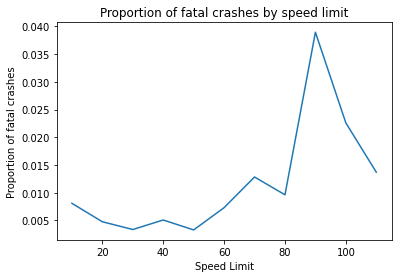

In [23]:
sns.lineplot(y=1, x='speedLimit',data=pivoted_df_speed)
plt.title('Proportion of fatal crashes by speed limit')
plt.xlabel('Speed Limit')
plt.ylabel('Proportion of fatal crashes')
plt.savefig('proportion_of_fatal_crashes_by_speed_limit')

#### Observations:
* There is a massive spike in proportion of fatalities when speed limit increases past 80.

#### Create dummy variables for categorical variables weather and light:

In [24]:
data = crashes
cat_vars = ['weatherA', 'light']
for var in cat_vars:
    cat_list = pd.get_dummies(crashes[var], prefix=var)
    data = data.join(cat_list)
data_vars = data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

In [25]:
data_final = data[to_keep]
data_final.columns.values

array(['carStationWagon', 'crashSeverity', 'holiday', 'suv', 'bicycle',
       'speedLimit', 'motorcycle', 'pedestrian', 'weatherA_Fine',
       'weatherA_Mist or Fog', 'weatherA_Rain', 'light_Bright sun',
       'light_Dark', 'light_Overcast', 'light_Twilight'], dtype=object)

In [26]:
data_final

,carStationWagon,crashSeverity,holiday,suv,bicycle,speedLimit,motorcycle,pedestrian,weatherA_Fine,weatherA_Mist or Fog,weatherA_Rain,light_Bright sun,light_Dark,light_Overcast,light_Twilight
0,1.0,0,0,0,0,50.0,0,0.0,1,0,0,1,0,0,0
1,1.0,0,0,0,0,50.0,0,0.0,1,0,0,1,0,0,0
2,2.0,0,0,0,0,50.0,0,0.0,1,0,0,1,0,0,0
3,1.0,0,0,0,0,50.0,0,0.0,1,0,0,1,0,0,0
4,1.0,0,0,0,0,80.0,0,0.0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814715,2.0,0,0,0,0,50.0,0,0.0,1,0,0,0,0,1,0
814716,0.0,0,0,1,0,100.0,0,0.0,1,0,0,1,0,0,0
814717,2.0,0,0,1,0,50.0,0,0.0,1,0,0,0,1,0,0
814718,1.0,0,0,0,0,80.0,0,0.0,0,1,0,0,1,0,0


#### Now balance the classes using SMOTE (Synthetic Minority Oversampling Technique)

In [27]:
X = data_final.loc[:, data_final.columns != 'crashSeverity']
y = data_final.loc[:, data_final.columns == 'crashSeverity']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['crashSeverity'])
# # we can Check the numbers of our data
print("Length of oversampled data is: ",len(os_data_X))
print("Number of survivals in oversampled data: ",len(os_data_y[os_data_y['crashSeverity']==0]))
print("Number of deaths: ",len(os_data_y[os_data_y['crashSeverity']==1]))
print("Proportion of survivals in oversampled data is: ",len(os_data_y[os_data_y['crashSeverity']==0])/len(os_data_X))
print("Proportion of deaaths in oversampled data is: ",len(os_data_y[os_data_y['crashSeverity']==1])/len(os_data_X))

Length of oversampled data is:  1102740
Number of survivals in oversampled data:  551370
Number of deaths:  551370
Proportion of survivals in oversampled data is:  0.5
Proportion of deaaths in oversampled data is:  0.5


#### **Data looks good. Can start modelling:**

In [28]:
X = os_data_X
y = os_data_y['crashSeverity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Model 1: Lasso regression
lasso_cv = LassoCV(cv=5, random_state=0)
lasso_cv.fit(X_train, y_train)
y_pred_lasso = lasso_cv.predict(X_test)
y_pred_lasso = (y_pred_lasso > 0.5).astype(int)
lasso_coef = pd.DataFrame({'Variable':X_train.columns,'Coefficient':lasso_cv.coef_})
lasso_coef = lasso_coef[lasso_coef['Coefficient']!=0]

print('Lasso regression classification report:')
print(classification_report(y_test, y_pred_lasso))

#Model 2: Logistic regression with recursive feature elimination
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
coefficients = pd.DataFrame({"Variable": X_train.columns, "Coefficient": logreg.coef_[0]})
print("Logistic regression variable selection summary:")
#print(coefficients)
print('Logistic regression classification report:')
print(classification_report(y_test, y_pred))

# Model 3: Random forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Random forest classification report:')
print(classification_report(y_test, y_pred_rf))

Lasso regression classification report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.71    165228
           1       0.71      0.78      0.74    165594

    accuracy                           0.73    330822
   macro avg       0.73      0.73      0.73    330822
weighted avg       0.73      0.73      0.73    330822



c:\Users\joshg\.virtualenvs\INFO204-VvZpTAgv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression variable selection summary:
Logistic regression classification report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72    165228
           1       0.71      0.78      0.75    165594

    accuracy                           0.73    330822
   macro avg       0.74      0.73      0.73    330822
weighted avg       0.74      0.73      0.73    330822

Random forest classification report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74    165228
           1       0.72      0.85      0.78    165594

    accuracy                           0.76    330822
   macro avg       0.77      0.76      0.76    330822
weighted avg       0.77      0.76      0.76    330822



In [29]:
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost.predict(X_test)

# Print the classification report and accuracy score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.68      0.74    165228
           1       0.73      0.85      0.78    165594

    accuracy                           0.76    330822
   macro avg       0.77      0.76      0.76    330822
weighted avg       0.77      0.76      0.76    330822



In [30]:
print('Lasso regression variable selection summary:')
print(lasso_coef)

print("Logistic regression variable selection summary:")
print(coefficients)
print()

Lasso regression variable selection summary:
           Variable  Coefficient
0   carStationWagon    -0.091633
2               suv    -0.001060
4        speedLimit     0.008469
5        motorcycle     0.113554
6        pedestrian     0.289232
9     weatherA_Rain    -0.011968
11       light_Dark     0.056736
12   light_Overcast    -0.017946
Logistic regression variable selection summary:
                Variable  Coefficient
0        carStationWagon    -0.445388
1                holiday    -0.121685
2                    suv    -0.203821
3                bicycle     0.346915
4             speedLimit     0.043359
5             motorcycle     1.178960
6             pedestrian     2.005350
7          weatherA_Fine    -0.591696
8   weatherA_Mist or Fog    -0.861719
9          weatherA_Rain    -0.877273
10      light_Bright sun    -0.767202
11            light_Dark    -0.248343
12        light_Overcast    -0.827914
13        light_Twilight    -0.734417



In [31]:
importances = pd.DataFrame({'Feature':X_train.columns, 'Importance':rf.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).reset_index(drop=True)

# Print feature importances
print('Random forest feature importances:')
print(importances)

Random forest feature importances:
                 Feature  Importance
0             speedLimit    0.528839
1        carStationWagon    0.203624
2             pedestrian    0.106532
3             motorcycle    0.054405
4             light_Dark    0.021273
5                    suv    0.017797
6         light_Overcast    0.013075
7                holiday    0.012380
8                bicycle    0.009623
9          weatherA_Rain    0.008508
10      light_Bright sun    0.007502
11         weatherA_Fine    0.006968
12        light_Twilight    0.005481
13  weatherA_Mist or Fog    0.003992


#### **Observations:**
* Logistic Regression model and Lasso perform very similarly, both predicting fatalities and non-fatalities at 68-78%. Something important to note is that lasso managed to use far fewer variables (6 vs. 13) for the same performance, so in practice I would prefer this model for interpretability. 

* Random forest performs the best at predicting fatality (85%), however correctly predicting non-fatalities not as accurate (68%) as lasso and logistic regression.

* All of my models are better at predicting fatalities than non-fatalities.

#### **Conclusions:**

#### With an F-1 score of 0.76, the random forest model performed the best of the models I tested. Across all of the models, the most important features were speed limit, motorcycle and pedestrian. Weather didn't seem to have the effect that I thought it would.

